In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for pre-processing
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.feature_selection import SelectKBest,f_regression

#for model construction #neural network
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Activation
from keras.models import Sequential

#for parameter optimization
from sklearn.model_selection import GridSearchCV

#for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score

#visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.utils import shuffle
from yellowbrick.regressor import PredictionError
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  #hide any pandas warnings

## ABM construction

In [5]:
import math
from scipy import stats
from enum import Enum
import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

class State(Enum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RESISTANT = 2
    DEAD = 3
    ISOLATED = 4 #After identifying being infected

#10k population, actually around 600 million population in 2020 in UK
population = 2000

def number_state(model, s):
    n=0
    for a in model.schedule.agents:
        if a.state == s:
            n+=1
    return n

def number_infected(model):
    #deteced infected and undetected infected
    return number_state(model, State.INFECTED) + number_state(model, State.ISOLATED)


def number_susceptible(model):
    return number_state(model, State.SUSCEPTIBLE)


def number_resistant(model):
    return number_state(model, State.RESISTANT)


def number_dead(model):
    return number_state(model, State.DEAD)

def number_isolated(model):
    return number_state(model, State.ISOLATED)


class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(
        self,
        num_nodes=population,
        avg_node_degree=6,
        initial_outbreak_size=2,
        virus_spread_chance=0.1,
        virus_check_frequency=0.2,
        recovery_chance=0.1,
        curing_days=0,
        testing_days=0,
        time_steps=0,
        wasinfected=False,
        wasresistant=False
    ):

        self.num_nodes = num_nodes
        prob = avg_node_degree / self.num_nodes
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = initial_outbreak_size 
        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.curing_days = curing_days
        self.testing_days = testing_days
        self.time_steps = time_steps
        self.wasinfected = wasinfected
        self.wasresistant = wasresistant

        self.datacollector = DataCollector(
            {
                "Infected": number_infected,
                "Susceptible": number_susceptible,
                "Resistant": number_resistant,
                "Dead": number_dead,
                "Isolated": number_isolated
            }
        )

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(
                i,
                self,
                State.SUSCEPTIBLE,
                self.virus_spread_chance,
                self.virus_check_frequency,
                self.recovery_chance,
                self.curing_days,
                self.testing_days,
                self.time_steps,
                self.wasinfected,
                self.wasresistant
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = State.INFECTED
            a.wasinfected = True

        self.running = True
        self.datacollector.collect(self)

    def resistant_susceptible_ratio(self):
        try:
            return number_state(self, State.RESISTANT) / number_state(
                self, State.SUSCEPTIBLE
            )
        except ZeroDivisionError:
            return math.inf

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in range(n):
            self.step()

class VirusAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        virus_spread_chance,
        virus_check_frequency,
        recovery_chance,
        curing_days,
        testing_days,
        time_steps,
        wasinfected,
        wasresistant
    ):
        super().__init__(unique_id, model)

        self.state = initial_state

        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.curing_days = curing_days
        self.testing_days = testing_days
        self.time_steps = time_steps
        self.wasinfected = wasinfected
        self.wasresistant = wasresistant

    def try_to_infect_neighbors(self):
        
        #both susceptible and resistant neighbors could be infected
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        healthy_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == State.SUSCEPTIBLE or agent.state == State.RESISTANT
        ]
        
        for a in healthy_neighbors:
            chance = self.decide_virus_spread_chance(a)
                
            if self.random.random() < chance:
                a.state = State.INFECTED
                a.wasinfected = True                    
                    
    def decide_virus_spread_chance(self, neighbor):
        
        #check whether neighbor is immune
        resistant_neighbor = neighbor.wasinfected == True or neighbor.wasresistant == True

        if resistant_neighbor == False:
            chance =  self.virus_spread_chance
        else:
            chance =  self.virus_spread_chance*(1-0.84)
        
        #if the infected self-isolate, the spread chance would decrease
        if self.state == State.ISOLATED:
            chance = chance * 0.3

        #if the infected previously get vaccination, the reproduce chance would reduce as well
        if self.wasresistant == True:
            return chance*0.55
        else:
            return chance


    def step(self): #refer to one day
        
        #infect neighbor #distance #not only 8neighbors
        if self.state == State.INFECTED or self.state == State.ISOLATED:
            self.try_to_infect_neighbors()
        
        #only close contact would be tested and have results after 7 days
        if self.state == State.INFECTED:
            if self.testing_days == 7:
                self.state = State.ISOLATED
                self.testing_days = 0
            else:
                self.testing_days += 1
        
        #cure detected infected people (ISOLATED)
        if self.state == State.ISOLATED:
            if self.curing_days == 30:
                if self.random.random() < self.recovery_chance:
                    # Success
                    self.state = State.SUSCEPTIBLE
                else:
                    # Failed and died after a month
                    self.state = State.DEAD
                self.curing_days = 0
                
            else:
                self.curing_days += 1
        
        #SUSCEPTIBLE gets vaccination
        if self.state == State.SUSCEPTIBLE:
            #vaccination_rate = vr['fullvacci_num'][self.time_steps]/1000000/population
            vaccination_rate = 0.02
            if self.random.random() < vaccination_rate: #quite_low
                self.state = State.RESISTANT
                self.wasresistant = True
            
        self.time_steps += 1 #time pass

# Data Creation

In [6]:
number_of_steps = 60

columns = ['Infected' + str(n) for n in range(0,10,1)] + ['Resistant' + str(n) for n in range(0,10,1)] + ['Susceptible' + str(n) for n in range(0,10,1)]
columns.append('maximum')
columns_all = ['Infected' + str(n) for n in range(0,number_of_steps,1)] + ['Resistant' + str(n) for n in range(0,number_of_steps,1)] + ['Susceptible' + str(n) for n in range(0,number_of_steps,1)]

dataset = pd.DataFrame([],columns = columns)
dataset_all = pd.DataFrame([],columns = columns_all)

for iteration in range(100):
    
    model = VirusOnNetwork()
    number_agents = np.zeros((3,number_of_steps))
   
    for i in range(number_of_steps):
        # Store the number of infected
        number_agents[0,i] = number_infected(model)
        number_agents[1,i] = number_resistant(model)
        number_agents[2,i] = number_susceptible(model)
        model.step()
    
    #target
    maximum = max(number_agents[0])
    reshape_data = np.reshape(number_agents[:,:10],(1,30))
    reshape_data = np.append(reshape_data,[maximum])
    dataset = pd.concat([dataset,pd.DataFrame([reshape_data],columns = columns)])

    reshape_data_all = np.reshape(number_agents,(1,3*number_of_steps))
    dataset_all = pd.concat([dataset_all,pd.DataFrame(reshape_data_all,columns = columns_all)])  
    

In [7]:
dataset.head(10)

,Infected0,Infected1,Infected2,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,...,Susceptible1,Susceptible2,Susceptible3,Susceptible4,Susceptible5,Susceptible6,Susceptible7,Susceptible8,Susceptible9,maximum
0,2.0,2.0,4.0,5.0,7.0,8.0,10.0,13.0,20.0,29.0,...,1954.0,1916.0,1871.0,1826.0,1793.0,1753.0,1714.0,1677.0,1635.0,1635.0
0,2.0,3.0,6.0,12.0,19.0,28.0,41.0,62.0,107.0,159.0,...,1962.0,1915.0,1873.0,1825.0,1779.0,1733.0,1682.0,1601.0,1526.0,1720.0
0,2.0,3.0,3.0,6.0,7.0,11.0,25.0,47.0,77.0,104.0,...,1957.0,1908.0,1857.0,1826.0,1790.0,1743.0,1686.0,1617.0,1558.0,1710.0
0,2.0,3.0,7.0,13.0,23.0,47.0,64.0,108.0,140.0,220.0,...,1953.0,1901.0,1858.0,1810.0,1744.0,1693.0,1626.0,1565.0,1458.0,1748.0
0,2.0,2.0,4.0,4.0,5.0,9.0,11.0,14.0,17.0,24.0,...,1943.0,1907.0,1870.0,1820.0,1787.0,1751.0,1715.0,1683.0,1645.0,1652.0
0,2.0,4.0,5.0,6.0,8.0,13.0,20.0,29.0,46.0,67.0,...,1949.0,1914.0,1879.0,1839.0,1788.0,1741.0,1693.0,1647.0,1602.0,1673.0
0,2.0,3.0,5.0,10.0,14.0,27.0,49.0,76.0,111.0,155.0,...,1964.0,1919.0,1879.0,1836.0,1786.0,1734.0,1677.0,1607.0,1534.0,1747.0
0,2.0,3.0,5.0,7.0,12.0,18.0,23.0,35.0,51.0,80.0,...,1962.0,1923.0,1895.0,1858.0,1812.0,1769.0,1721.0,1673.0,1612.0,1666.0
0,2.0,4.0,4.0,7.0,12.0,18.0,33.0,52.0,81.0,122.0,...,1957.0,1920.0,1879.0,1836.0,1795.0,1736.0,1688.0,1629.0,1564.0,1728.0
0,2.0,4.0,7.0,11.0,21.0,33.0,53.0,72.0,109.0,168.0,...,1958.0,1919.0,1866.0,1817.0,1770.0,1723.0,1666.0,1597.0,1508.0,1715.0


In [8]:
dataset_all.head()

,Infected0,Infected1,Infected2,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,...,Susceptible50,Susceptible51,Susceptible52,Susceptible53,Susceptible54,Susceptible55,Susceptible56,Susceptible57,Susceptible58,Susceptible59
0,2.0,2.0,4.0,5.0,7.0,8.0,10.0,13.0,20.0,29.0,...,29.0,37.0,44.0,55.0,62.0,71.0,81.0,88.0,99.0,105.0
0,2.0,3.0,6.0,12.0,19.0,28.0,41.0,62.0,107.0,159.0,...,51.0,62.0,76.0,90.0,98.0,104.0,112.0,117.0,125.0,127.0
0,2.0,3.0,3.0,6.0,7.0,11.0,25.0,47.0,77.0,104.0,...,44.0,57.0,68.0,73.0,88.0,98.0,102.0,104.0,106.0,108.0
0,2.0,3.0,7.0,13.0,23.0,47.0,64.0,108.0,140.0,220.0,...,79.0,95.0,106.0,118.0,121.0,126.0,133.0,136.0,141.0,139.0
0,2.0,2.0,4.0,4.0,5.0,9.0,11.0,14.0,17.0,24.0,...,33.0,37.0,42.0,50.0,59.0,66.0,76.0,84.0,95.0,108.0


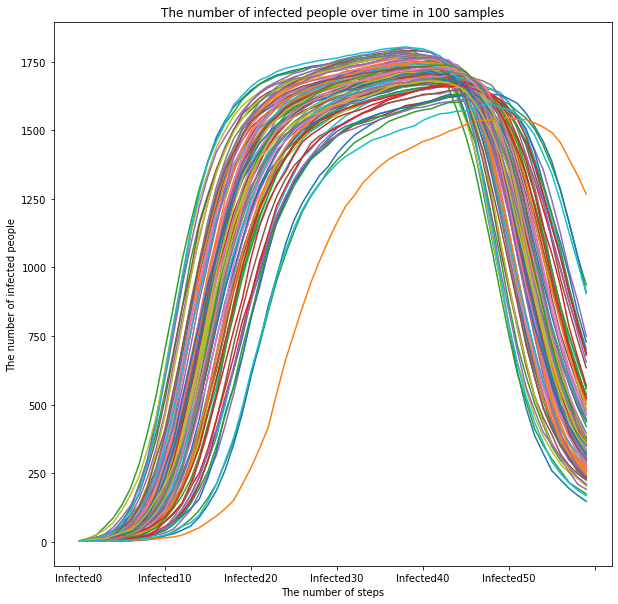

In [9]:
number_of_steps = 60
dataset_all.T[:number_of_steps].plot(legend = False, figsize = (10,10), 
                                     xlabel = 'The number of steps', 
                                     ylabel = 'The number of infected people',
                                     title = 'The number of infected people over time in 100 samples')

plt.savefig('InfectedNum.png', bbox_inches='tight', dpi=300)
plt.show()

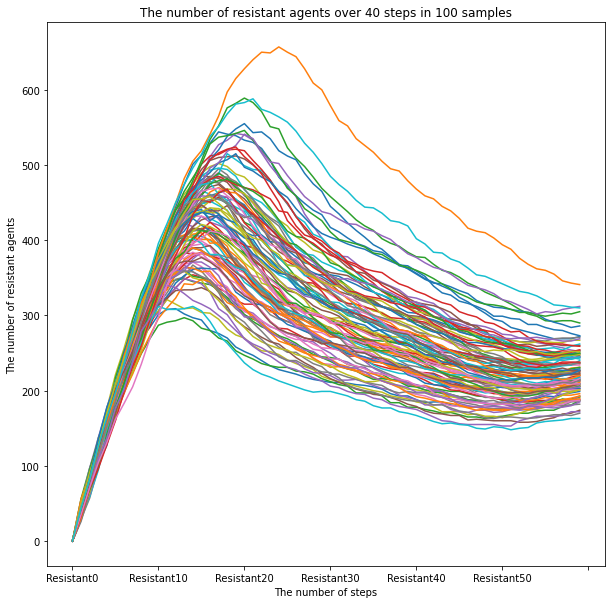

In [10]:
dataset_all.T[number_of_steps:number_of_steps*2].plot(legend = False, figsize = (10,10),
                                     xlabel = 'The number of steps', 
                                     ylabel = 'The number of resistant agents',
                                     title = 'The number of resistant agents over 40 steps in 100 samples')
plt.savefig('ResistantNum.png', bbox_inches='tight', dpi=300)
plt.show()

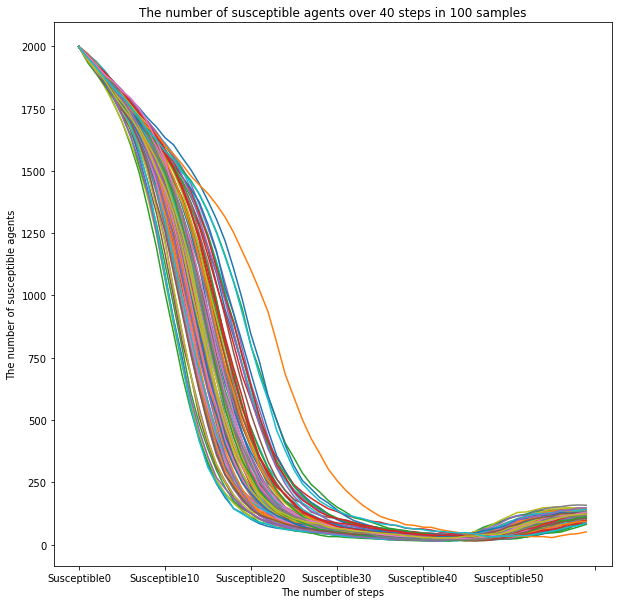

In [11]:
dataset_all.T[number_of_steps*2:number_of_steps*3].plot(legend = False, figsize = (10,10),
                                     xlabel = 'The number of steps', 
                                     ylabel = 'The number of susceptible agents',
                                     title = 'The number of susceptible agents over 40 steps in 100 samples')
plt.savefig('SusceptNum.png', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
dataset_all.to_csv('dataset_all',index=False) 

In [13]:
dataset.to_csv('dataset',index=False) 

## Data Cleaning

In [14]:
dataset = pd.read_csv('dataset')
dataset

,Infected0,Infected1,Infected2,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,...,Susceptible1,Susceptible2,Susceptible3,Susceptible4,Susceptible5,Susceptible6,Susceptible7,Susceptible8,Susceptible9,maximum
0,2.0,2.0,4.0,5.0,7.0,8.0,10.0,13.0,20.0,29.0,...,1954.0,1916.0,1871.0,1826.0,1793.0,1753.0,1714.0,1677.0,1635.0,1635.0
1,2.0,3.0,6.0,12.0,19.0,28.0,41.0,62.0,107.0,159.0,...,1962.0,1915.0,1873.0,1825.0,1779.0,1733.0,1682.0,1601.0,1526.0,1720.0
2,2.0,3.0,3.0,6.0,7.0,11.0,25.0,47.0,77.0,104.0,...,1957.0,1908.0,1857.0,1826.0,1790.0,1743.0,1686.0,1617.0,1558.0,1710.0
3,2.0,3.0,7.0,13.0,23.0,47.0,64.0,108.0,140.0,220.0,...,1953.0,1901.0,1858.0,1810.0,1744.0,1693.0,1626.0,1565.0,1458.0,1748.0
4,2.0,2.0,4.0,4.0,5.0,9.0,11.0,14.0,17.0,24.0,...,1943.0,1907.0,1870.0,1820.0,1787.0,1751.0,1715.0,1683.0,1645.0,1652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.0,3.0,7.0,13.0,23.0,51.0,75.0,127.0,200.0,308.0,...,1960.0,1914.0,1866.0,1814.0,1747.0,1699.0,1620.0,1514.0,1376.0,1731.0
96,2.0,2.0,3.0,9.0,11.0,17.0,24.0,44.0,72.0,106.0,...,1963.0,1926.0,1887.0,1858.0,1821.0,1793.0,1751.0,1693.0,1625.0,1727.0
97,2.0,4.0,5.0,7.0,11.0,14.0,25.0,39.0,65.0,96.0,...,1951.0,1914.0,1877.0,1837.0,1801.0,1754.0,1717.0,1643.0,1574.0,1722.0
98,2.0,7.0,9.0,12.0,22.0,33.0,42.0,68.0,106.0,156.0,...,1948.0,1909.0,1863.0,1809.0,1758.0,1715.0,1660.0,1586.0,1501.0,1680.0


In [15]:
dataset_all = pd.read_csv('dataset_all')
dataset_all

,Infected0,Infected1,Infected2,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,...,Susceptible50,Susceptible51,Susceptible52,Susceptible53,Susceptible54,Susceptible55,Susceptible56,Susceptible57,Susceptible58,Susceptible59
0,2.0,2.0,4.0,5.0,7.0,8.0,10.0,13.0,20.0,29.0,...,29.0,37.0,44.0,55.0,62.0,71.0,81.0,88.0,99.0,105.0
1,2.0,3.0,6.0,12.0,19.0,28.0,41.0,62.0,107.0,159.0,...,51.0,62.0,76.0,90.0,98.0,104.0,112.0,117.0,125.0,127.0
2,2.0,3.0,3.0,6.0,7.0,11.0,25.0,47.0,77.0,104.0,...,44.0,57.0,68.0,73.0,88.0,98.0,102.0,104.0,106.0,108.0
3,2.0,3.0,7.0,13.0,23.0,47.0,64.0,108.0,140.0,220.0,...,79.0,95.0,106.0,118.0,121.0,126.0,133.0,136.0,141.0,139.0
4,2.0,2.0,4.0,4.0,5.0,9.0,11.0,14.0,17.0,24.0,...,33.0,37.0,42.0,50.0,59.0,66.0,76.0,84.0,95.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.0,3.0,7.0,13.0,23.0,51.0,75.0,127.0,200.0,308.0,...,72.0,80.0,95.0,104.0,110.0,114.0,124.0,125.0,127.0,127.0
96,2.0,2.0,3.0,9.0,11.0,17.0,24.0,44.0,72.0,106.0,...,57.0,66.0,78.0,85.0,91.0,98.0,110.0,116.0,124.0,130.0
97,2.0,4.0,5.0,7.0,11.0,14.0,25.0,39.0,65.0,96.0,...,44.0,55.0,65.0,81.0,98.0,108.0,109.0,110.0,118.0,119.0
98,2.0,7.0,9.0,12.0,22.0,33.0,42.0,68.0,106.0,156.0,...,51.0,65.0,75.0,89.0,92.0,102.0,108.0,117.0,120.0,123.0


In [16]:
# generate dataset
X0, y0 = dataset.drop('maximum', axis = 1), dataset['maximum']

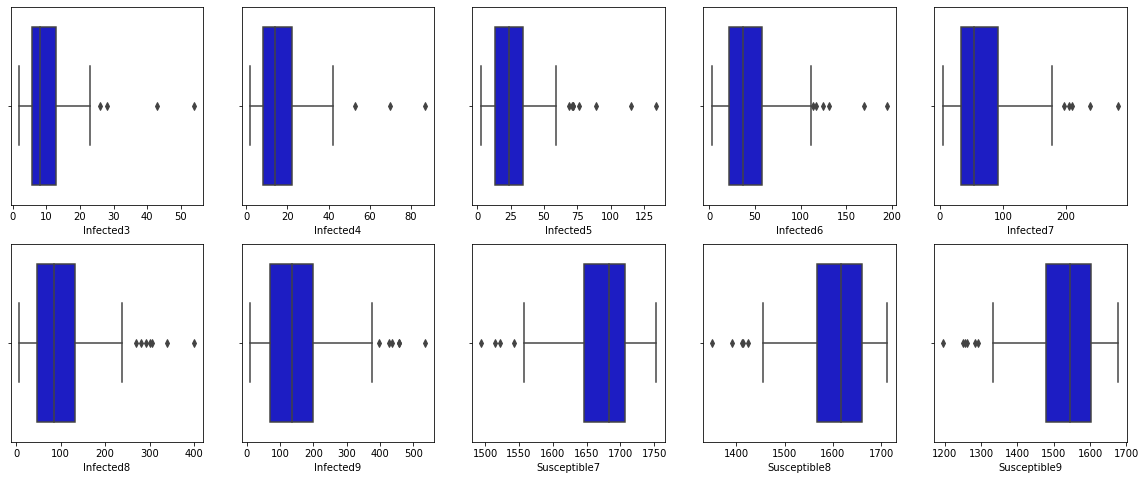

In [17]:
colors = ["#0101DF", "#DF0101"]

f, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Infected3", data=X0, palette=colors, ax=axes[0,0])

sns.boxplot(x="Infected4", data=X0, palette=colors, ax=axes[0,1])

sns.boxplot(x="Infected5", data=X0, palette=colors, ax=axes[0,2])

sns.boxplot(x="Infected6", data=X0, palette=colors, ax=axes[0,3])

sns.boxplot(x="Infected7", data=X0, palette=colors, ax=axes[0,4])

sns.boxplot(x="Infected8", data=X0, palette=colors, ax=axes[1,0])

sns.boxplot(x="Infected9", data=X0, palette=colors, ax=axes[1,1])

sns.boxplot(x="Susceptible7", data=X0, palette=colors, ax=axes[1,2])

sns.boxplot(x="Susceptible8", data=X0, palette=colors, ax=axes[1,3])

sns.boxplot(x="Susceptible9", data=X0, palette=colors, ax=axes[1,4])

plt.show()

In [18]:
Q1 = X0.quantile(0.25)
Q3 = X0.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

X = X0[~((X0 < (Q1 - 1.5 * IQR)) |(X0 > (Q3 + 1.5 * IQR))).any(axis=1)]
y = y0[~((X0 < (Q1 - 1.5 * IQR)) |(X0 > (Q3 + 1.5 * IQR))).any(axis=1)]

Infected0         0.00
Infected1         2.00
Infected2         3.25
Infected3         7.25
Infected4        14.00
Infected5        21.00
Infected6        36.25
Infected7        59.50
Infected8        85.75
Infected9       130.25
Resistant0        0.00
Resistant1        8.00
Resistant2       10.25
Resistant3       14.25
Resistant4       19.00
Resistant5       22.25
Resistant6       24.75
Resistant7       25.25
Resistant8       25.00
Resistant9       31.00
Susceptible0      0.00
Susceptible1     10.00
Susceptible2     11.50
Susceptible3     17.00
Susceptible4     24.00
Susceptible5     31.00
Susceptible6     36.50
Susceptible7     61.50
Susceptible8     92.50
Susceptible9    122.50
dtype: float64


In [19]:
print(X.shape)
print(y.shape)

(85, 30)
(85,)


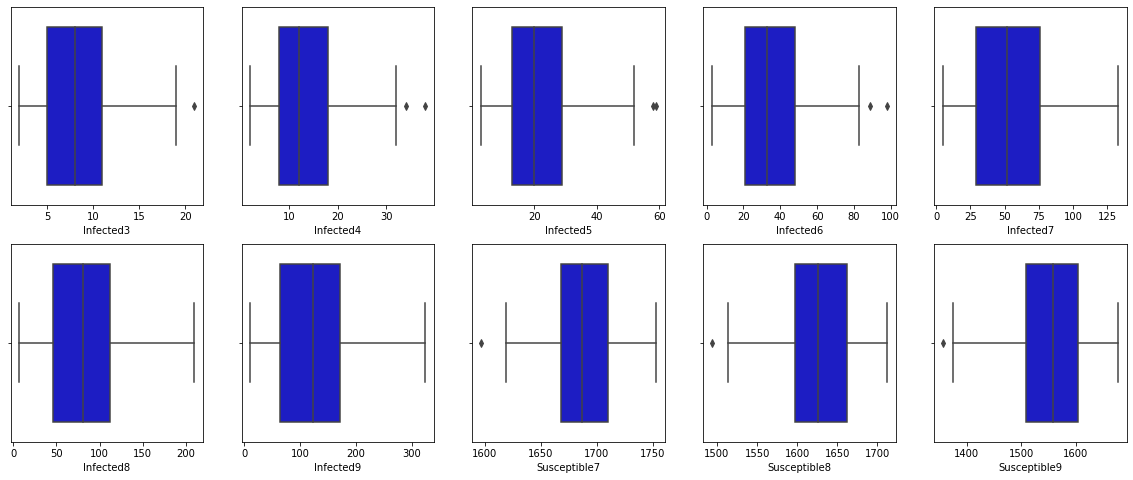

In [20]:
colors = ["#0101DF", "#DF0101"]

f, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Infected3", data=X, palette=colors, ax=axes[0,0])

sns.boxplot(x="Infected4", data=X, palette=colors, ax=axes[0,1])

sns.boxplot(x="Infected5", data=X, palette=colors, ax=axes[0,2])

sns.boxplot(x="Infected6", data=X, palette=colors, ax=axes[0,3])

sns.boxplot(x="Infected7", data=X, palette=colors, ax=axes[0,4])

sns.boxplot(x="Infected8", data=X, palette=colors, ax=axes[1,0])

sns.boxplot(x="Infected9", data=X, palette=colors, ax=axes[1,1])

sns.boxplot(x="Susceptible7", data=X, palette=colors, ax=axes[1,2])

sns.boxplot(x="Susceptible8", data=X, palette=colors, ax=axes[1,3])

sns.boxplot(x="Susceptible9", data=X, palette=colors, ax=axes[1,4])

plt.show()

# Feature selection - the Pearson correlation

In [22]:
# Create and fit selector
selector = SelectKBest(score_func=f_regression, k=10).fit(X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

new_X = X[list(features_df_new)]
features_list = list(features_df_new)
features_list

['Infected3',
 'Infected4',
 'Infected5',
 'Infected6',
 'Infected7',
 'Infected8',
 'Infected9',
 'Susceptible7',
 'Susceptible8',
 'Susceptible9']

In [23]:
selector.scores_

array([           nan, 4.16618629e+00, 2.11441880e+01, 6.40924637e+01,
       6.67181316e+01, 9.66005684e+01, 1.27914173e+02, 1.40377196e+02,
       1.52813121e+02, 1.52323582e+02,            nan, 1.00550863e-01,
       9.34192150e-01, 1.03487515e+00, 2.34011843e+00, 3.05051015e+00,
       6.94323771e+00, 1.11885478e+01, 1.56845343e+01, 2.46192912e+01,
                  nan, 6.65658115e-03, 2.91190660e-02, 1.97307906e+00,
       4.68509032e+00, 1.50382400e+01, 3.57586096e+01, 5.64643767e+01,
       8.20379264e+01, 1.01001634e+02])

In [25]:
def output_importance(model,train,model_name):
    rf_importances = pd.Series(model.feature_importances_, index = train.columns)

    #Sort importances
    sorted_importances = rf_importances.sort_values()

    fig, ax = plt.subplots(figsize = (5,9))
    sorted_importances.plot(kind = 'barh')
    ax.set_title(model_name + ' Feature importances')
    ax.set_xlabel('Feature importances', labelpad=15, size=14)
    ax.set_ylabel('Features', labelpad=15, size=14)
    plt.show()
    
def default_MSE(model,X,y):
    return np.round(np.absolute(np.mean(cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv=10))),2)

def default_RMSE(model,X,y):
    return np.round(np.mean(np.sqrt(np.absolute(cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv=10)))),2)

def default_MAE(model,X,y):
    return np.round(np.absolute(np.mean(cross_val_score(model, X, y, scoring = 'neg_mean_absolute_error', cv=10))),2)

def default_R2(model,X,y):
    return np.round(np.mean(cross_val_score(model, X, y, scoring = 'r2', cv=10)),2)

#Plot the first tree for random forest classifier
def output_tree(model,train,target,name):

    estimator = model
    feature_names = [i for i in train.columns]

    target_names = target.astype('str')

    export_graphviz(estimator, out_file=name+'.dot', 
                feature_names = feature_names,
                class_names = True,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

    from subprocess import call
    call(['dot', '-Tpng', name+'.dot', '-o', name+'.png', '-Gdpi=600'])
    
def R2(model,inp,out):
    prediction=model.predict(inp)
    return np.round(r2_score(out,prediction),2)

def RMSE(model,inp,out):
    prediction=model.predict(inp)
    return np.round(np.sqrt(mean_squared_error(out,prediction)),2)

def MSE(model,inp,out):
    prediction=model.predict(inp)
    return np.round(mean_squared_error(out,prediction),2)

def MAE(model,inp,out):
    prediction=model.predict(inp)
    return np.round(mean_absolute_error(out, prediction),2)

### Random forest

In [26]:
xlabel = []
mae_train = []
mae_test = []

for k in range(1,31,1):
    xlabel.append(k)
    selector = SelectKBest(score_func=f_regression, k=k).fit(X, y)
    cols = selector.get_support(indices=True)
    features_df_new = X.iloc[:,cols]
    
    new_X0 = X[list(features_df_new)]
    model = RandomForestRegressor()
    
    train_X, test_X, target_y, target_test_y = train_test_split(new_X0, y, test_size=.2, random_state=40)
    model.fit(train_X, target_y)
    mae_train.append(MAE(model,train_X,target_y))
    mae_test.append(MAE(model,test_X,target_test_y))

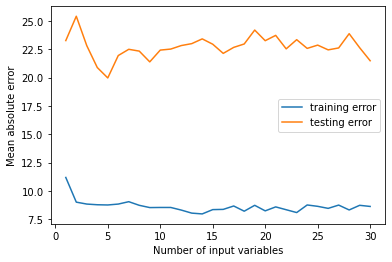

In [27]:
plt.plot(xlabel,mae_train, label = 'training error')
plt.plot(xlabel,mae_test, label = 'testing error')
plt.xlabel('Number of input variables')
plt.ylabel('Mean absolute error')
plt.figure(num = 1, figsize = (100,100))
plt.legend()
plt.show()

### Linear regressor

In [28]:
xlabel = []
mae_train = []
mae_test = []

for k in range(1,31,1):
    xlabel.append(k)
    selector = SelectKBest(score_func=f_regression, k=k).fit(X, y)
    cols = selector.get_support(indices=True)
    features_df_new = X.iloc[:,cols]
    
    new_X0 = X[list(features_df_new)]
    model = LinearRegression()
    
    train_X, test_X, target_y, target_test_y = train_test_split(new_X0, y, test_size=.2, random_state=40)
    model.fit(train_X, target_y)
    mae_train.append(MAE(model,train_X,target_y))
    mae_test.append(MAE(model,test_X,target_test_y))

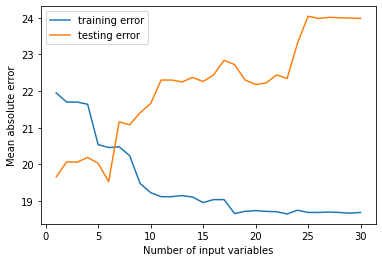

In [29]:
plt.plot(xlabel,mae_train, label = 'training error')
plt.plot(xlabel,mae_test, label = 'testing error')
plt.xlabel('Number of input variables')
plt.ylabel('Mean absolute error')
plt.figure(num = 1, figsize = (100,100))
plt.legend()
plt.show()

### ANN

In [30]:
def ann(h1=5,h2=5,input_dim = 10):
    
    model = Sequential()
    model.add(Dense(units=h1, input_dim=input_dim, activation='relu'))
    model.add(Dense(units=h2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'sgd')
    return model

In [33]:
new_X = X[features_list]
new_X.describe()

,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,Susceptible7,Susceptible8,Susceptible9
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,8.364706,13.835294,22.894118,36.082353,55.823529,85.282353,128.694118,1684.235294,1622.235294,1549.458824
std,4.116885,7.699485,13.284455,21.367093,32.752381,49.827228,74.734454,31.714368,47.170321,69.089065
min,2.000000,2.000000,3.000000,3.000000,5.000000,7.000000,11.000000,1597.000000,1494.000000,1357.000000
25%,5.000000,8.000000,13.000000,21.000000,29.000000,46.000000,64.000000,1668.000000,1597.000000,1508.000000
50%,8.000000,12.000000,20.000000,33.000000,52.000000,81.000000,123.000000,1687.000000,1626.000000,1558.000000
75%,11.000000,18.000000,29.000000,48.000000,76.000000,112.000000,171.000000,1710.000000,1662.000000,1604.000000
max,21.000000,38.000000,59.000000,98.000000,133.000000,210.000000,324.000000,1753.000000,1712.000000,1677.000000


# Modelling

### Split the data

In [34]:
features_list

['Infected3',
 'Infected4',
 'Infected5',
 'Infected6',
 'Infected7',
 'Infected8',
 'Infected9',
 'Susceptible7',
 'Susceptible8',
 'Susceptible9']

In [35]:
train0, test0, target, target_test = train_test_split(X, y, test_size=.2, random_state=40)
train, test = train0[features_list], test0[features_list]

### Linear Regression --- parameter optimization

In [37]:
param_grid = [{
    'fit_intercept': [True, False],
    'normalize':[True, False],
}]

reg=LinearRegression()
grid_search = GridSearchCV(reg, param_grid, cv=10,scoring='neg_mean_squared_error',verbose=10,n_jobs=-1)
grid_search.fit(train, target)
reg=grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'fit_intercept': True, 'normalize': True}


In [38]:
perm_linear = PermutationImportance(reg, random_state=1, scoring = 'neg_mean_squared_error').fit(train, target)
eli5.show_weights(perm_linear, feature_names = features_list)

Weight,Feature
15302.8225 ± 4906.6275,Infected8
8480.9184 ± 3906.1893,Susceptible8
1303.8879 ± 366.6176,Susceptible7
669.3587 ± 191.3680,Infected4
597.5953 ± 135.7084,Infected6
506.0649 ± 281.6248,Infected3
363.1518 ± 121.2912,Infected9
70.7281 ± 31.5484,Infected5
36.7231 ± 58.1824,Susceptible9
3.1123 ± 9.4184,Infected7


In [39]:
params = np.append(reg.intercept_,reg.coef_)
linear_predictions = reg.predict(train)

newX = train.copy()
newX.insert(0, 'Constant', 1)
MSE = (sum((target-linear_predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.iloc[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

    Coefficients  Standard Errors  t values  Probabilities
0       680.4931          387.564     1.756          0.084
1         3.9971            2.291     1.744          0.086
2        -2.2032            1.950    -1.130          0.263
3        -0.4012            1.667    -0.241          0.811
4        -0.8022            1.210    -0.663          0.510
5         0.0246            0.977     0.025          0.980
6         1.6784            1.338     1.254          0.215
7         0.1598            0.898     0.178          0.859
8        -0.7539            0.596    -1.266          0.211
9         1.3888            0.912     1.524          0.133
10       -0.0574            0.671    -0.086          0.932


In [40]:
features_list

['Infected3',
 'Infected4',
 'Infected5',
 'Infected6',
 'Infected7',
 'Infected8',
 'Infected9',
 'Susceptible7',
 'Susceptible8',
 'Susceptible9']

In [41]:
X[features_list].describe()

,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,Susceptible7,Susceptible8,Susceptible9
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,8.364706,13.835294,22.894118,36.082353,55.823529,85.282353,128.694118,1684.235294,1622.235294,1549.458824
std,4.116885,7.699485,13.284455,21.367093,32.752381,49.827228,74.734454,31.714368,47.170321,69.089065
min,2.000000,2.000000,3.000000,3.000000,5.000000,7.000000,11.000000,1597.000000,1494.000000,1357.000000
25%,5.000000,8.000000,13.000000,21.000000,29.000000,46.000000,64.000000,1668.000000,1597.000000,1508.000000
50%,8.000000,12.000000,20.000000,33.000000,52.000000,81.000000,123.000000,1687.000000,1626.000000,1558.000000
75%,11.000000,18.000000,29.000000,48.000000,76.000000,112.000000,171.000000,1710.000000,1662.000000,1604.000000
max,21.000000,38.000000,59.000000,98.000000,133.000000,210.000000,324.000000,1753.000000,1712.000000,1677.000000


In [42]:
# after feature selection and parameter optimization
def MSE(model,inp,out):
    prediction=model.predict(inp)
    return np.round(mean_squared_error(out,prediction),2)

print("MSE:",MSE(reg,test,target_test))
print("RMSE:",RMSE(reg,test,target_test))
print('R squared:',R2(reg,test,target_test))
print('MAE:',MAE(reg,test,target_test))


print('')
print('=================benchmark: using unfiltered data and default model==============')
print('')

reg0 = LinearRegression()
print("MSE:",default_MSE(reg0,X[features_list],y))
print("RMSE:",default_RMSE(reg0,X[features_list],y))
print('R squared:',default_R2(reg0,X[features_list],y))
print('MAE:',default_MAE(reg0,X[features_list],y))

MSE: 641.07
RMSE: 25.32
R squared: 0.6
MAE: 21.66

=================benchmark: using unfiltered data and default model==============

MSE: 860.43
RMSE: 27.62
R squared: 0.48
MAE: 22.41


### Decision tree regression --- parameter optimization

In [43]:
param_grid = [{ 
    'max_features': np.linspace(10,15,5).astype(int),
    'max_depth':np.linspace(2,7,6).astype(int),
    'min_samples_split':np.linspace(10,15,5).astype(int),
    'criterion':["mse"],
    'splitter':["best"],
    'min_samples_leaf':np.linspace(1,5,5).astype(int),
    'max_leaf_nodes':np.linspace(5,10,5).astype(int)
}]

DTR=DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(DTR, param_grid, cv=5,scoring='neg_mean_squared_error',verbose=10,n_jobs=-1)
grid_search.fit(train, target)
DTR=grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 5 folds for each of 3750 candidates, totalling 18750 fits
{'criterion': 'mse', 'max_depth': 3, 'max_features': 10, 'max_leaf_nodes': 6, 'min_samples_leaf': 5, 'min_samples_split': 10, 'splitter': 'best'}


In [44]:
DTR.feature_importances_

array([0.        , 0.        , 0.02798534, 0.        , 0.14385266,
       0.80653639, 0.        , 0.        , 0.        , 0.02162562])

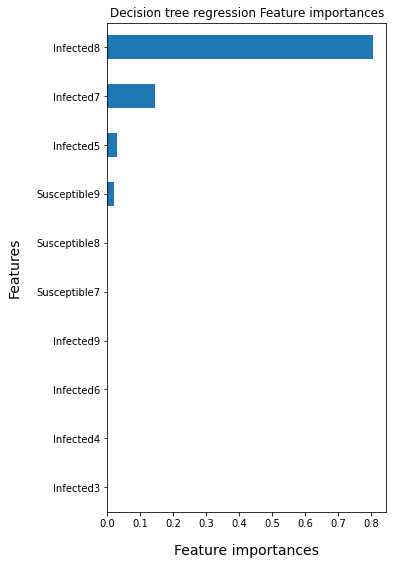

In [45]:
output_importance(DTR,train, 'Decision tree regression')

In [47]:
print("Decision Tree RMSE: ",RMSE(DTR,test,target_test))
print("Decision Tree MSE: ",MSE(DTR,test,target_test))
print("Decision Tree  MAE: ",MAE(DTR,test,target_test))
print("Decision Tree  R2: ",R2(DTR,test,target_test))

print('')
print('=================benchmark: using unfiltered data and default model==============')
print('')
default_dt = DecisionTreeRegressor()

print("Decision Tree RMSE: ", np.sqrt(default_MSE(default_dt,X[features_list],y)))
print("Decision Tree MSE: ",default_MSE(default_dt,X[features_list],y))
print("Decision Tree  MAE: ",default_MAE(default_dt,X[features_list],y))
print("Decision Tree  R2: ",default_R2(default_dt,X[features_list],y))

Decision Tree RMSE:  25.2
Decision Tree MSE:  635.23
Decision Tree  MAE:  21.06
Decision Tree  R2:  0.61

=================benchmark: using unfiltered data and default model==============

Decision Tree RMSE:  36.603415141213254
Decision Tree MSE:  1140.36
Decision Tree  MAE:  30.57
Decision Tree  R2:  0.09


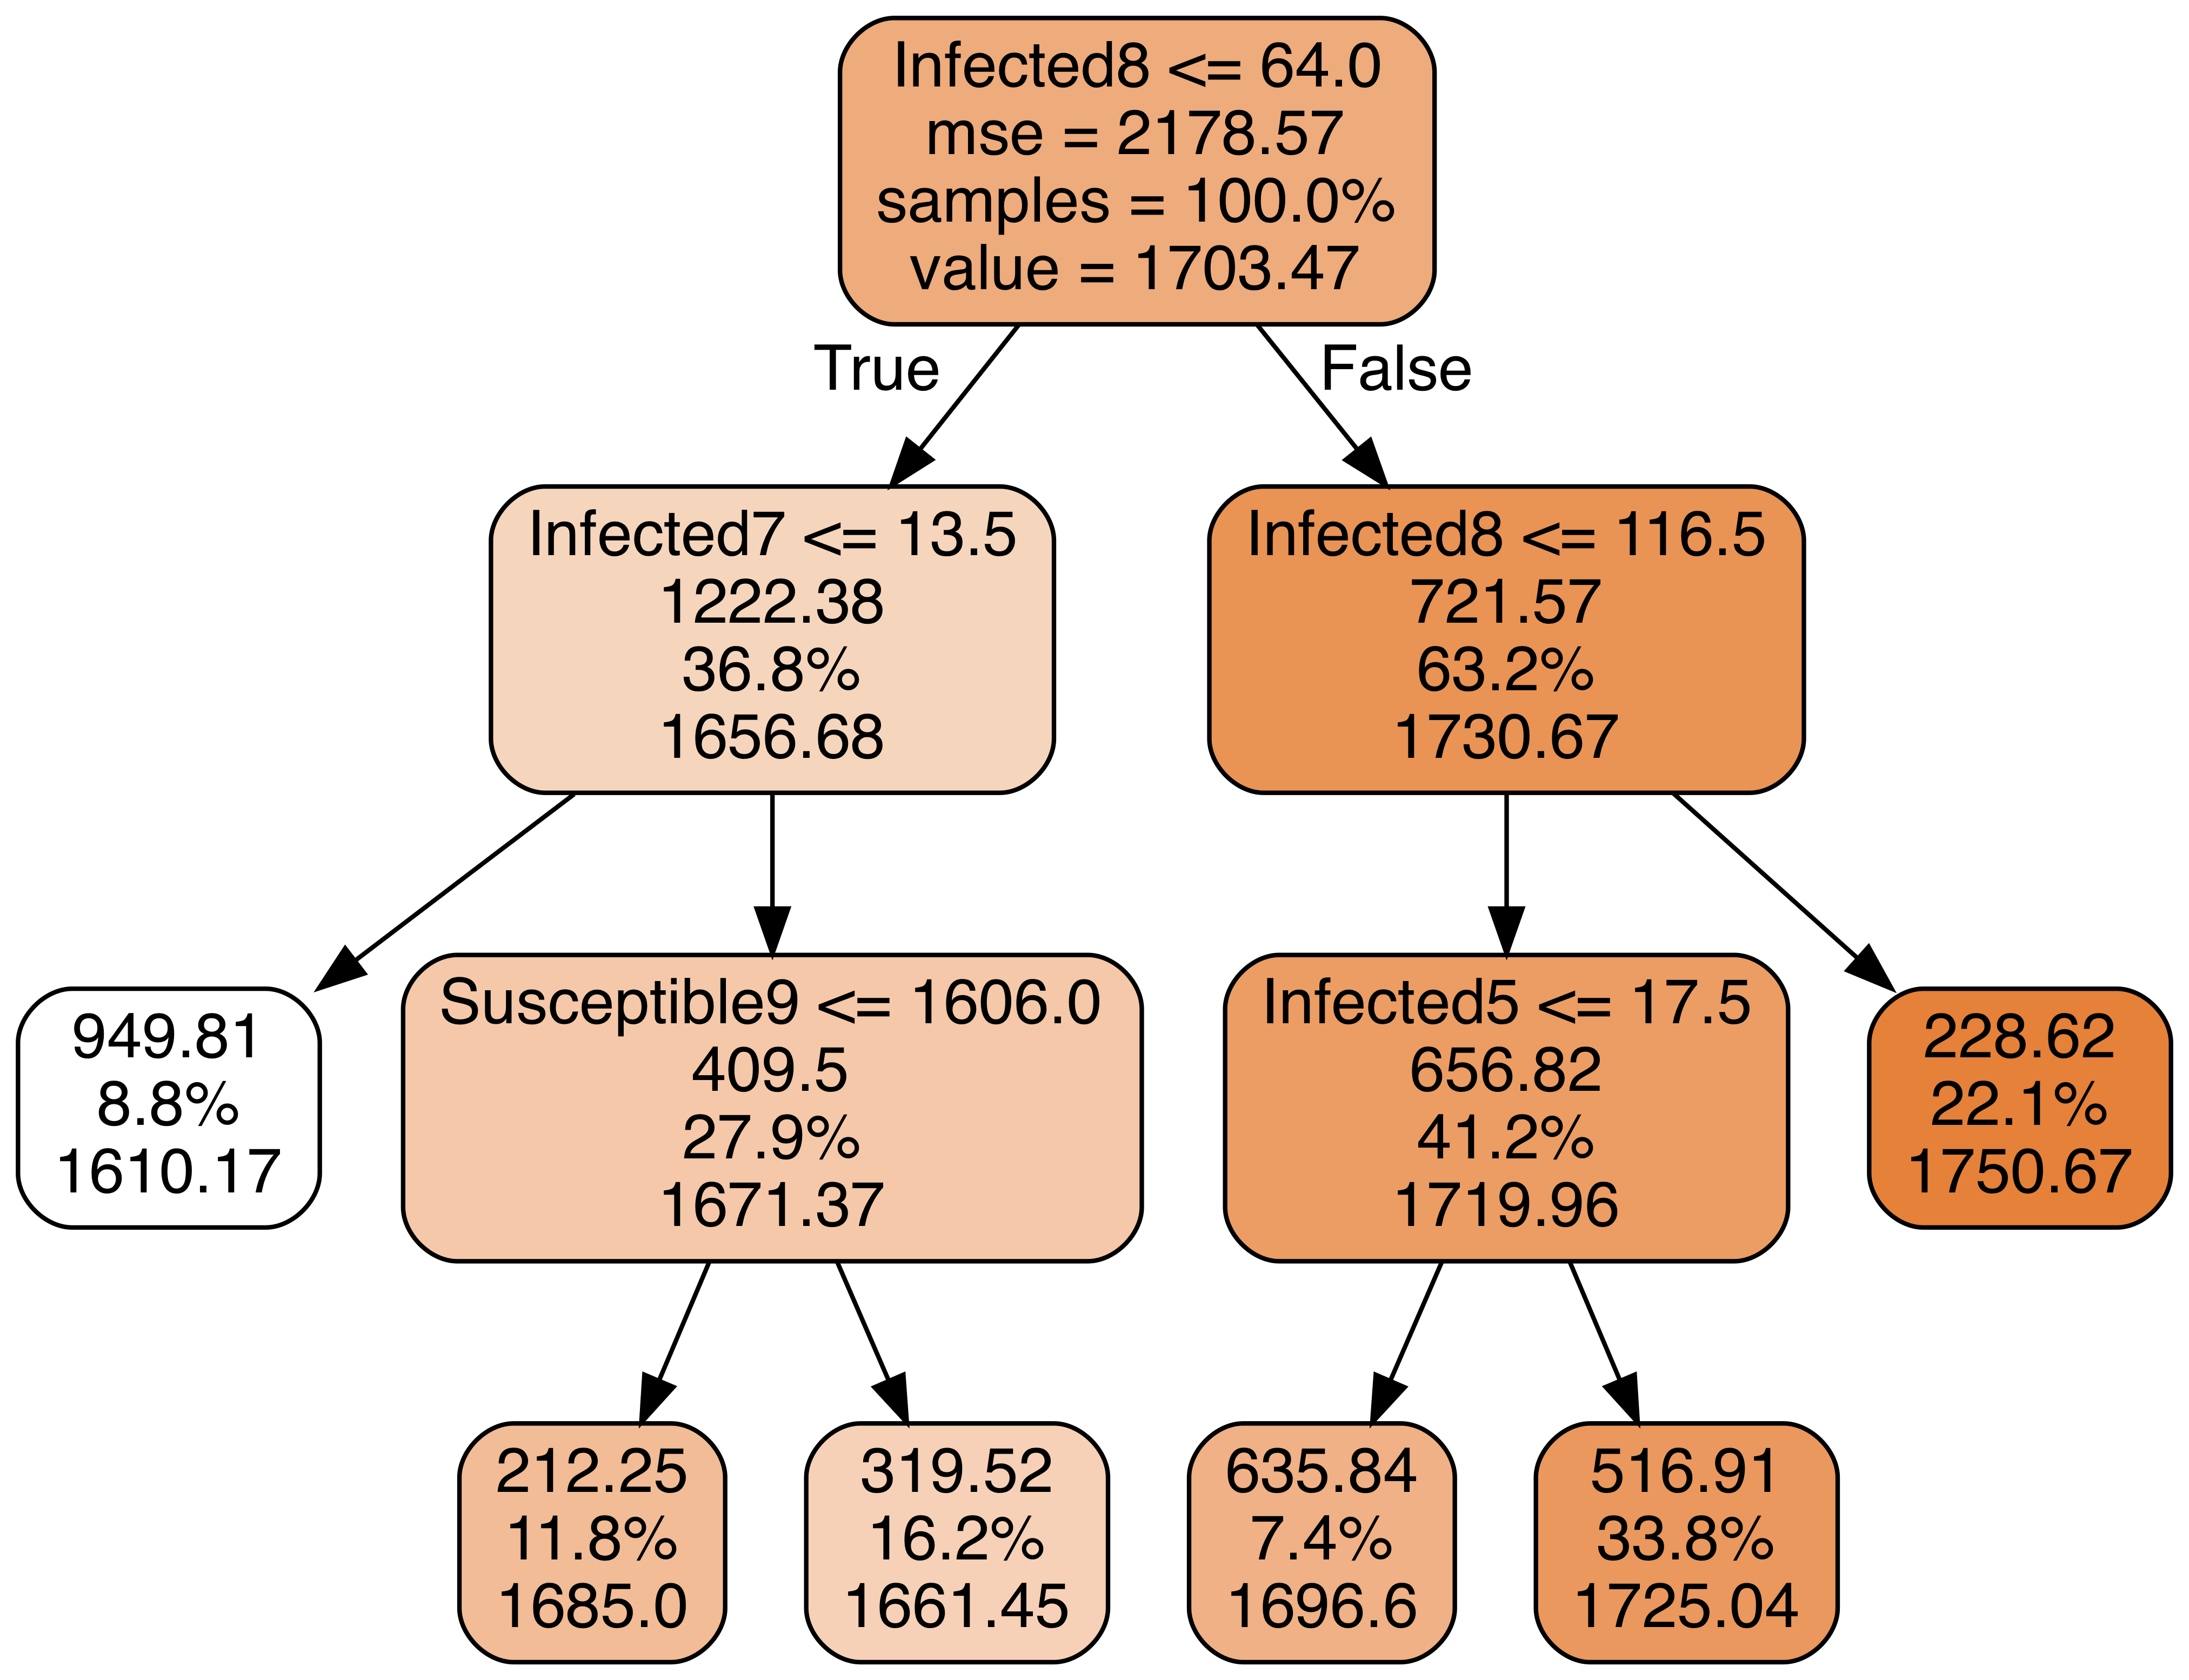

In [48]:
output_tree(DTR,train,target,'DTR')
Image(filename = 'DTR.png',width=600, height=800)

### Random forest regression --- parameter optimization

In [49]:
param_grid = [{
    'n_estimators': [70],
    'max_features': np.linspace(1,10,10).astype(int),
    'max_depth':np.linspace(1,10,10).astype(int),
    'min_samples_split':np.linspace(10,15,5).astype(int),
    'min_samples_leaf':np.linspace(1,5,5).astype(int),
    'criterion':['mse'],
    'bootstrap':[True],#,False
    'warm_start':[False],
    'ccp_alpha':[0.0]#5.0
}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(train,target)
forest_reg=grid_search.best_estimator_
print(grid_search.best_params_)
#{'bootstrap': True, 'ccp_alpha': 5.0, 'criterion': 'mse', 'max_depth': 40, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 10, 'warm_start': False}

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 70, 'warm_start': False}


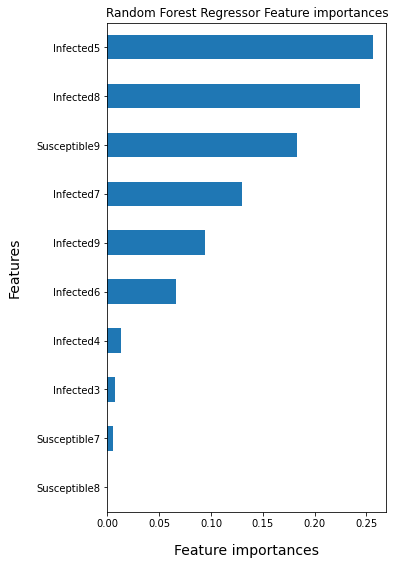

In [50]:
#Plot the feature importance for random forest classifier
output_importance(forest_reg,train, 'Random Forest Regressor')

In [51]:
forest_reg.feature_importances_

array([0.00697743, 0.01283395, 0.25642982, 0.06665713, 0.13041975,
       0.24393527, 0.09426212, 0.00574078, 0.        , 0.18274376])

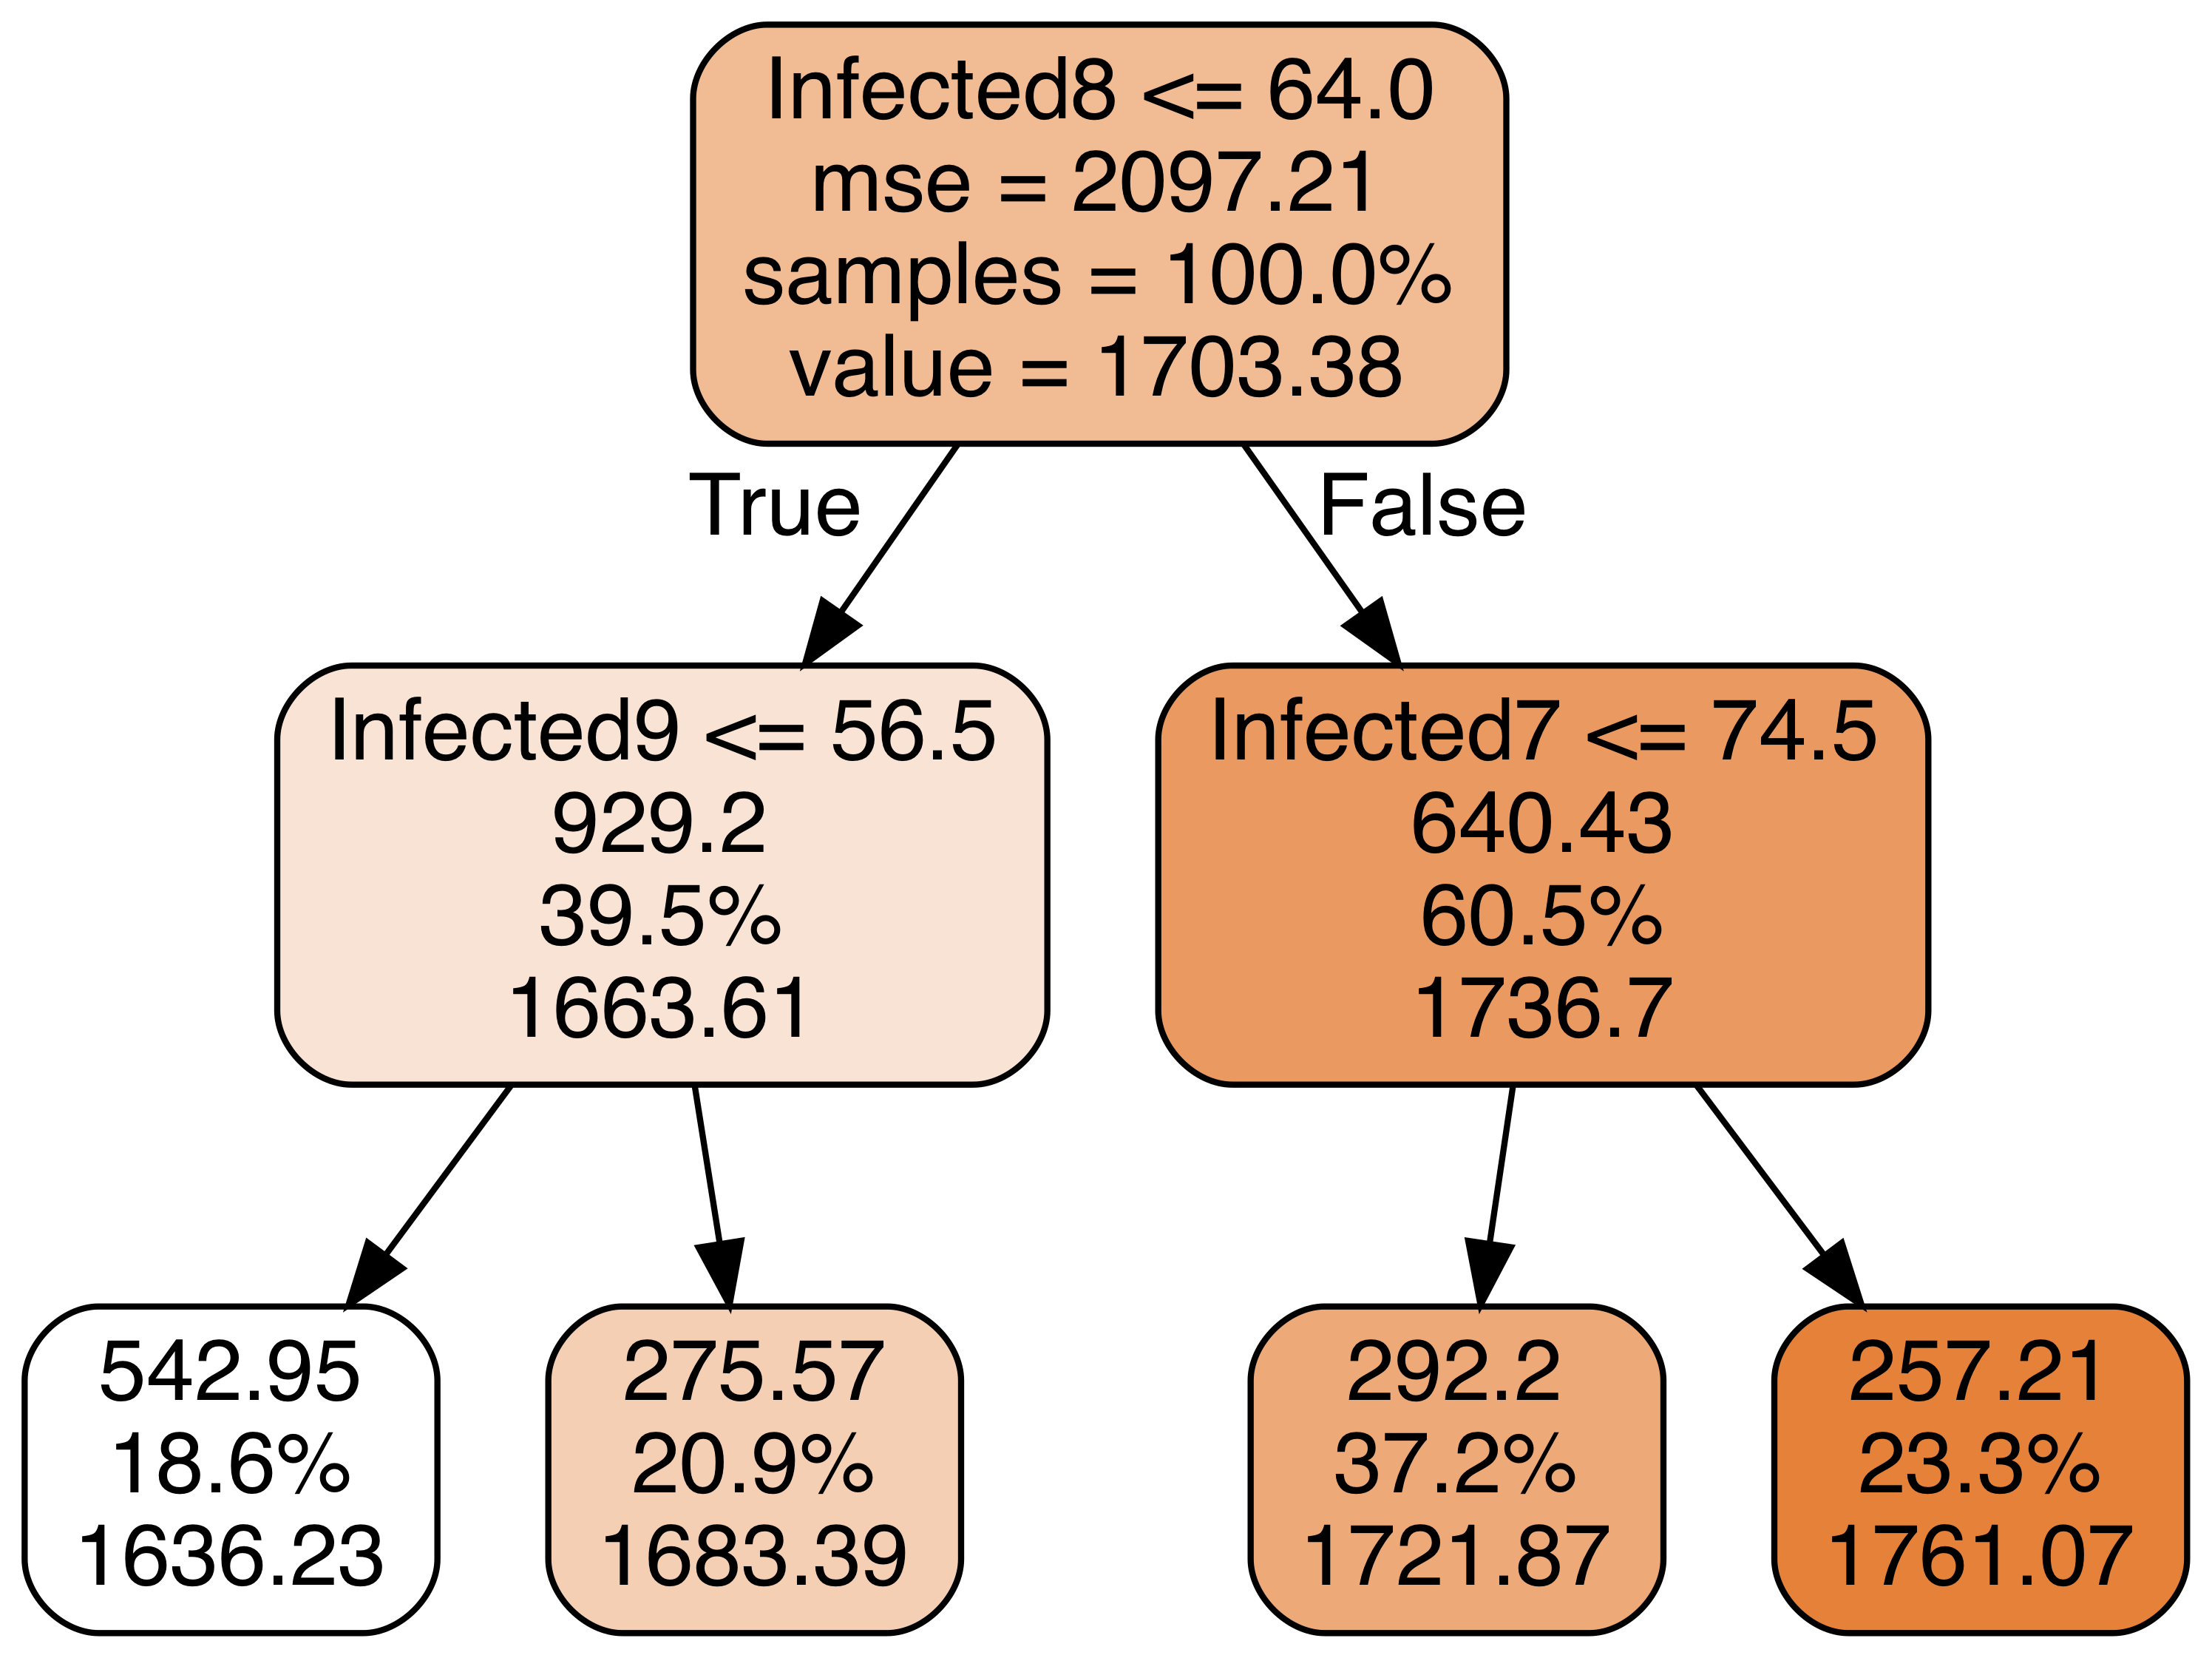

In [52]:
output_tree(forest_reg.estimators_[1],train,target,'rf')
Image(filename = 'rf.png',width=800, height=800)

In [53]:
print("Random Forest Regressor RMSE: ",RMSE(forest_reg,test,target_test))
print("Random Forest Regressor MSE: ",MSE(forest_reg,test,target_test))
print("Random Forest Regressor MAE: ",MAE(forest_reg,test,target_test))
print("Random Forest Regressor R2: ",R2(forest_reg,test,target_test))

print('')
print('=================benchmark: using unfiltered data and default model==============')
print('')

#benchmark
default_rf = RandomForestRegressor()
print("Random Forest Regressor RMSE: ", np.sqrt(default_MSE(default_rf,X,y)))
print("Random Forest Regressor MSE: ",default_MSE(default_rf,X,y))
print("Random Forest Regressor  MAE: ",default_MAE(default_rf,X,y))
print("Random Forest Regressor  R2: ",default_R2(default_rf,X,y))

Random Forest Regressor RMSE:  24.5
Random Forest Regressor MSE:  600.36
Random Forest Regressor MAE:  21.62
Random Forest Regressor R2:  0.63

=================benchmark: using unfiltered data and default model==============

Random Forest Regressor RMSE:  27.632227561309637
Random Forest Regressor MSE:  728.44
Random Forest Regressor  MAE:  22.52
Random Forest Regressor  R2:  0.46


### ANN --- Parameter optimization

In [55]:
def make_regression_ann(Optimizer_trial,h1=5,h2=5,input_dim=10):
    
    model = Sequential()
    model.add(Dense(units=h1, input_dim = input_dim, activation='relu'))
    model.add(Dense(units=h2))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model

# Feature Scaling

sc = StandardScaler()
tr_train = sc.fit_transform(train)
tr_test = sc.transform(test)

sc_target = StandardScaler()
tr_target = sc_target.fit_transform(np.array(target).reshape(-1,1))
tr_target_test = sc_target.fit_transform(np.array(target_test).reshape(-1,1))

In [56]:
# Listing all the parameters to try
Parameter_Trials={'batch_size':[5,10,20,25,30],
                      'epochs':[70,65,60],
                    'Optimizer_trial':['sgd']#'rmsprop','adam',
                 }
 
# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=1)
 
#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring='neg_mean_squared_error', 
                         cv=5)

#########################################
 
# Running Grid Search for different paramenters
grid_search.fit(tr_train, tr_target)

Epoch 1/70
11/11 [==============================] - 0s 955us/step - loss: 0.9876
Epoch 2/70
11/11 [==============================] - 0s 1ms/step - loss: 0.6748
Epoch 3/70
11/11 [==============================] - 0s 1ms/step - loss: 0.6553
Epoch 4/70
11/11 [==============================] - 0s 1ms/step - loss: 0.5877
Epoch 5/70
11/11 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 6/70
11/11 [==============================] - 0s 1ms/step - loss: 0.5459
Epoch 7/70
11/11 [==============================] - 0s 1ms/step - loss: 0.5042
Epoch 8/70
11/11 [==============================] - 0s 1ms/step - loss: 0.4023
Epoch 9/70
11/11 [==============================] - 0s 1ms/step - loss: 0.5525
Epoch 10/70
11/11 [==============================] - 0s 1ms/step - loss: 0.4604
Epoch 11/70
11/11 [==============================] - 0s 1ms/step - loss: 0.2835
Epoch 12/70
11/11 [==============================] - 0s 932us/step - loss: 0.5211
Epoch 13/70
11/11 [==========================

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fe254f074f0>,
             param_grid={'Optimizer_trial': ['sgd'],
                         'batch_size': [5, 10, 20, 25, 30],
                         'epochs': [70, 65, 60]},
             scoring='neg_mean_squared_error')

In [57]:
print('### Printing Best parameters ###')
print(grid_search.best_params_)

### Printing Best parameters ###
{'Optimizer_trial': 'sgd', 'batch_size': 5, 'epochs': 70}


In [58]:
ANN = grid_search.best_estimator_
y_pred = ANN.predict(tr_test)
# Scaling the predicted data back to original scale
prediction_ANN=sc_target.inverse_transform(y_pred)

4/4 [==============================] - 0s 1ms/step


In [59]:
print('MSE:',mean_squared_error(target_test,prediction_ANN))
print('r2:',r2_score(target_test,prediction_ANN))
print('mae:',mean_absolute_error(target_test,prediction_ANN))

MSE: 686.1177814769394
r2: 0.5752821152637019
mae: 20.390919404871322


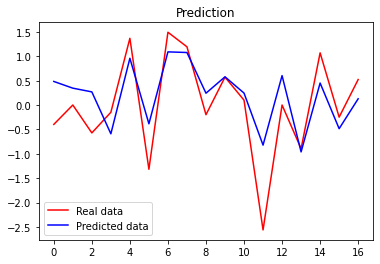

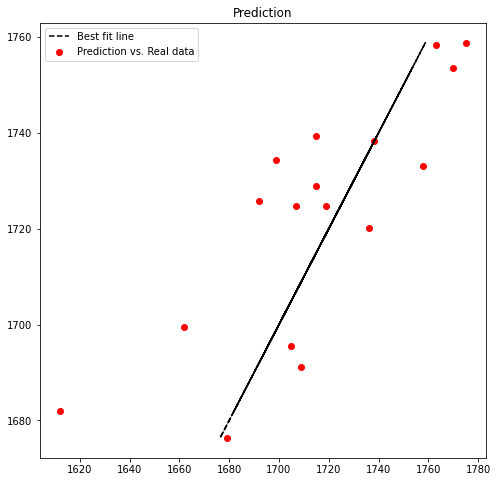

In [60]:
plt.plot(list(tr_target_test), color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

plt.figure(figsize = (8,8))
plt.scatter(list(target_test), prediction_ANN, color = 'red', label = 'Prediction vs. Real data')
plt.plot(prediction_ANN,prediction_ANN, 'k--',color = 'black', label = 'Best fit line')
plt.title('Prediction')
plt.legend()
plt.show()

In [61]:
# serialize model to JSON
from keras.models import model_from_json
ANN_json = ANN.model.to_json()
with open("bestANN.json", "w") as json_file:
    json_file.write(ANN_json)
# serialize weights to HDF5
ANN.model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [62]:
# load json and create model
json_file = open('bestANN.json', 'r')
loaded_ANN_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_ANN_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(loss='mean_squared_error', optimizer='sgd')

Loaded model from disk


In [63]:
# evaluate loaded model on test data
y_pred_loaded = loaded_model.predict(tr_test)

# Scaling the predicted data back to original scale
prediction_ANN_loaded=sc_target.inverse_transform(y_pred_loaded)

print('MSE:',mean_squared_error(target_test,prediction_ANN_loaded))
print('r2:',r2_score(target_test,prediction_ANN_loaded))
print('mae:',mean_absolute_error(target_test,prediction_ANN_loaded))

MSE: 686.1177814769394
r2: 0.5752821152637019
mae: 20.390919404871322


In [64]:
y_pred = loaded_model.predict(tr_test)
# Scaling the predicted data back to original scale
prediction_ANN=sc_target.inverse_transform(y_pred)

In [65]:
perm = PermutationImportance(loaded_model, random_state=1, scoring = 'neg_mean_squared_error').fit(tr_train, tr_target)
eli5.show_weights(perm, feature_names = features_list)

Weight,Feature
0.4433 ± 0.1368,Infected6
0.3146 ± 0.1149,Infected4
0.3014 ± 0.1725,Infected7
0.2398 ± 0.0688,Susceptible7
0.1959 ± 0.1208,Susceptible9
0.1919 ± 0.1193,Infected9
0.1652 ± 0.0855,Infected3
0.1466 ± 0.0853,Infected5
0.0167 ± 0.0224,Infected8
0.0101 ± 0.0116,Susceptible8


In [69]:
y.shape

(85,)

In [70]:
y = y.reset_index(drop=True)
X = X.reset_index(drop=True)

def default_ANN():
    
    ANN0=make_regression_ann('sgd',h1=10,h2=0,input_dim=30)

    groups = []
    for g in range(1,6):
        groups += [g for i in range(17)]
    
    groups = shuffle(groups)

    sc_X = StandardScaler()
    tr_X = sc_X.fit_transform(X[:])
    tr_X = pd.DataFrame(tr_X)

    sc_y = StandardScaler()
    tr_y = sc_y.fit_transform(np.array(y[:]).reshape(-1,1))
    tr_y = pd.DataFrame(tr_y)

    MSE_list = []
    MAE_list = []
    RMSE_list = []
    R2_list = []

    kf = GroupKFold(n_splits=5)
    for train_s, test_s in kf.split(tr_X, tr_y, groups=groups):
        ANN0.fit(tr_X.loc[train_s],tr_y.loc[train_s])
        MSE_list.append(mean_squared_error(y.loc[test_s],sc_y.inverse_transform(ANN0.predict(tr_X.loc[test_s]))))
    MAE_list.append(mean_absolute_error(y.loc[test_s],sc_y.inverse_transform(ANN0.predict(tr_X.loc[test_s]))))
    RMSE_list.append(np.sqrt(mean_squared_error(y.loc[test_s],sc_y.inverse_transform(ANN0.predict(tr_X.loc[test_s])))))
    R2_list.append(r2_score(y.loc[test_s],sc_y.inverse_transform(ANN0.predict(tr_X.loc[test_s]))))
    
    return np.mean(MSE_list),np.mean(MAE_list),np.mean(RMSE_list),np.mean(R2_list)

ANN0_MSE,ANN0_MAE,ANN0_RMSE,ANN0_R2 = np.round(default_ANN(),2)


3/3 [==============================] - 0s 2ms/step - loss: 1.0880


### Performance Matrix

In [71]:
reg0 = LinearRegression()
DTR0 = DecisionTreeRegressor(random_state=42)
forest_reg0 = RandomForestRegressor()

In [72]:
# without feature selection and parameter optimization

print("MSE:")
print("Linear Regression: ",default_MSE(reg0,X,y))
print("Decision Tree: ",default_MSE(DTR0,X,y))
print("Random Forest Regressor: ",default_MSE(forest_reg0,X,y))
print("Neural Network: ",ANN0_MSE)

print('====================================')
print("RMSE:")
print("Linear Regression: ",default_RMSE(reg0,X,y))
print("Decision Tree: ",default_RMSE(DTR0,X,y))
print("Random Forest Regressor: ",default_RMSE(forest_reg0,X,y))
print("Neural Network: ",ANN0_RMSE)

print('====================================')
print('R squared:')
print("Linear Regression : ",default_R2(reg0,X,y))
print("Decision Tree : ",default_R2(DTR0,X,y))
print("Random Forest Regressor : ",default_R2(forest_reg0,X,y))
print("Neural Network: ",ANN0_R2)

print('====================================')
print('MAE:')
print("Linear Regression : ",default_MAE(reg0,X,y))
print("Decision Tree : ",default_MAE(DTR0,X,y))
print("Random Forest Regressor : ",default_MAE(forest_reg0,X,y))
print("Neural Network: ",ANN0_MAE)

MSE:
Linear Regression:  1008.39
Decision Tree:  1138.13
Random Forest Regressor:  743.02
Neural Network:  2089.91
RMSE:
Linear Regression:  30.18
Decision Tree:  32.74
Random Forest Regressor:  26.29
Neural Network:  36.76
R squared:
Linear Regression :  0.37
Decision Tree :  0.09
Random Forest Regressor :  0.48
Neural Network:  -0.0
MAE:
Linear Regression :  24.38
Decision Tree :  27.22
Random Forest Regressor :  22.57
Neural Network:  29.47


In [73]:
# after feature selection and parameter optimization

print("MSE:")
print("Linear Regression: ",MSE(reg,test,target_test))
print("Decision Tree: ",MSE(DTR,test,target_test))
print("Random Forest Regressor: ",MSE(forest_reg,test,target_test))
print("ANN: ",mean_squared_error(target_test,prediction_ANN))

print('====================================')
print("RMSE:")
print("Linear Regression: ",RMSE(reg,test,target_test))
print("Decision Tree: ",RMSE(DTR,test,target_test))
print("Random Forest Regressor: ",RMSE(forest_reg,test,target_test))
print("ANN: ",np.sqrt(mean_squared_error(target_test,prediction_ANN)))

print('====================================')
print('R squared:')
print("Linear Regression : ",R2(reg,test,target_test))
print("Decision Tree : ",R2(DTR,test,target_test))
print("Random Forest Regressor : ",R2(forest_reg,test,target_test))
print("ANN: ",r2_score(target_test,prediction_ANN))

print('====================================')
print('MAE:')
print("Linear Regression : ",MAE(reg,test,target_test))
print("Decision Tree : ",MAE(DTR,test,target_test))
print("Random Forest Regressor : ",MAE(forest_reg,test,target_test))
print("ANN: ",mean_absolute_error(target_test,prediction_ANN))

MSE:
Linear Regression:  641.07
Decision Tree:  635.23
Random Forest Regressor:  600.36
ANN:  686.1177814769394
RMSE:
Linear Regression:  25.32
Decision Tree:  25.2
Random Forest Regressor:  24.5
ANN:  26.193850069757584
R squared:
Linear Regression :  0.6
Decision Tree :  0.61
Random Forest Regressor :  0.63
ANN:  0.5752821152637019
MAE:
Linear Regression :  21.66
Decision Tree :  21.06
Random Forest Regressor :  21.62
ANN:  20.390919404871322


### Plot prediction and true value

#### Random forest

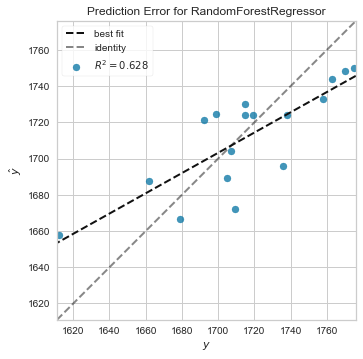

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [74]:
visualizer = PredictionError(forest_reg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(test, target_test)  # Evaluate the model on the test data
visualizer.show()

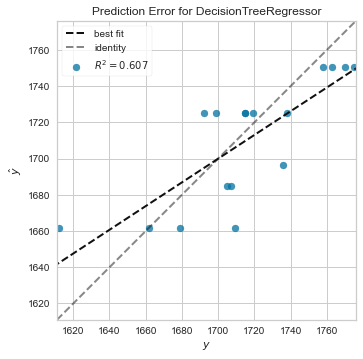

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [75]:
visualizer = PredictionError(DTR)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(test, target_test)  # Evaluate the model on the test data
visualizer.show()

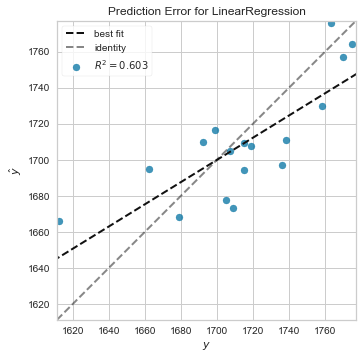

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [76]:
visualizer = PredictionError(reg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(test, target_test)  # Evaluate the model on the test data
visualizer.show() 

## Classification Modelling

In [ ]:
param_grid = [{
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'tol':[1e-3,2e-3,3e-3,1e-2,9e-4],
    'C':np.linspace(0,1,40),
}]

Logist=LogisticRegression()
grid_search = GridSearchCV(Logist, param_grid, cv=5,scoring='neg_mean_squared_error',verbose=10,n_jobs=-1)
#grid_search.fit(train_rf, target_rf)
#Logist=grid_search.best_estimator_

Logist.fit(train_rf, target_rf)
#print(grid_search.best_params_)